# Minianalysis: Last year used vs. *t* years into future (conservative version)

- filename: lastYearUsed_vs_x_Years_Into_Future_conservative_SEs.ipynb

Updates
    - 2018-05-06: the "conservative" version means refers to how we record outputs of the models. Previously, each DV resulted in a separate regression and contributed distinct observation to final data. Now I'm averaging across all DVs for an article, so that each article == one observation
    
    - 2016-03-31: 
        - made the code handle additional GSS years 2014 and 2016 (originally it was written to go up to 2012)
        - made it so that the separate regressions for each DV are average together (so one (article_id, year) = 1 datapoint, 
        rather than (article_id, year, DV) = 1 data point as before)
    description: 

Description
- Take models from an article, run them on the last year of GSS the article used, and compare them vs that model on future waves of GSS. Each difference in (year_future - year_last) counts as one observation, i.e. each article generates many data points. Howev


inputs:

outputs:



In [3]:
from __future__ import division

import pandas as pd
pd.set_option('use_inf_as_na', True) 
import pickle, cPickle
import sys
sys.path.append('../')    
import GSSUtility as GU # note, this imports the .PY file, so if I made changes to the IPYNB file, I first need to convert it 
                        # to PY for changes to actually take effect
                        # conversion can be done with 'jupyter nbconvert --to script GSSUtility.py'import numpy as np
from numpy import nan
import statsmodels.formula.api as smf 
import random
from scipy.stats import pearsonr, ttest_ind, ttest_rel
import numpy as np
from numpy import nanmean, nanstd
import time
from collections import Counter
from collections import defaultdict

In [4]:
try :
    %rm ../GSSUtility.pyc # remove this file because otherwise it will be used instead of the updated .py file
    reload(GU)
except:
    pass

In [ ]:
if __name__ == "__main__":    

    try :
        %rm ../GSSUtility.pyc # remove this file because otherwise it will be used instead of the updated .py file
        reload(GU)
    except:
        pass
    
    pathToData = '../../Data/'
    dataCont = GU.dataContainer(pathToData)
    
    # DEFINE DATA STRUCTURE FOR OUTPUT OF REGRESSION MODELS WE WILL RUN
    group1 = 'on_last_year_of_data'
    group2 = 'on_future_year'    
    output = defaultdict(dict)
    groups = [group1, group2]
    outcomes = ['propSig_ControlVars', 'paramSizesNormed_ControlVars', 'Rs', 'adjRs',
                'propSig_CentralVars', 'paramSizesNormed_CentralVars'] #'pvalues_CentralVars'
    
    for yr in range(1, 2016-1972+1): # this was 43... should it be 45 now? or maybe even higher? because i want to be able
                                  # to use 44 (2016-1972) as an actual 'key' for this dictionary
#         output[yr] = {}
        output[yr]['metadata'] = {}
        output[yr]['metadata']['last_GSS_year_used'] = []
        output[yr]['metadata']['future_GSS_year'] = []
        output[yr]['metadata']['articleID'] = []
        for group in groups:
            output[yr][group] = {}
            for outcome in outcomes:
                output[yr][group][outcome] = []
    
    # SELECT articleClasses WE WANT TO RUN 
    articlesToUse = GU.filterArticles(dataCont.articleClasses, 
                                      GSSYearsUsed=True, 
                                      GSSYearsPossible=True, 
                                      centralIVs=False, 
                                      linearModels=False)            
    print 'len of articleClasses:', len(articlesToUse)

    #     for article in articlesToUse: 
    
    # NOW RUN ALL THE MODELS
    for article in articlesToUse:
    #for article in random.sample(articlesToUse, 200):
#     for article in [a for a in articlesToUse if a.articleID == 4124]:
    
        print '\n\n============================================\nProcessing article:', article.articleID
 
        RHS = article.IVs + article.controls
        
        for DV in article.DVs:
            
            # the 3 lines below is the model estimated on the last year of data used, and stays constant when i put it into
            # the output data structure. the loop below only goes over "future possible years"
            maxYearUsed = max(article.GSSYearsUsed)    

            resOnDataUsed = GU.runModel(dataCont, maxYearUsed, DV, RHS) # "original" models run on max year of data used
            if not resOnDataUsed: continue

            # get column names of 'central variables'; this is tricky because some hve been dummy-fied, or standardized
            # and then Control variables are all the params - Central - Intercept
            centralVars = []            
            for civ in article.centralIVs:
                for param in resOnDataUsed.params.index:
                    if civ in param: centralVars.append(param)
            controlVars = set(resOnDataUsed.params.index) - set(centralVars + ['Intercept'])
            
            # NOW ITERATE OVER "FUTURE" YEARS AND RUN REGRESSIONS ON EACH
            futureYearsPossible = [yr for yr in article.GSSYearsPossible if yr > maxYearUsed]
            for futureYear in futureYearsPossible:
                resOnFutureYear = GU.runModel(dataCont, futureYear, DV, RHS) # models run on min year of future data
                if not resOnFutureYear: continue

                # AVOIDING the check below because often, in future years, the # of params will be different because some 
                # categorical variable will have an additional level added to it
                # Checks on which results to record
                if len(resOnDataUsed.params) != len(resOnFutureYear.params):
                    print 'The number of variables in original model is different from the number in "future" model. Skipping.'                    
                    continue
    
                results = [resOnDataUsed, resOnFutureYear]
     
                # RECORD THE OUTPUTS OF THE REGRESSIONS
                for i in range(2):
                    output[futureYear - maxYearUsed][groups[i]]['Rs'].append(results[i].rsquared) 
                    output[futureYear - maxYearUsed][groups[i]]['adjRs'].append(results[i].rsquared_adj) 
                    
                    # CONTROL VARS
                    if (len(controlVars)>0) and np.any([1 for el in controlVars if el in resOnFutureYear.params]):
                        output[futureYear - maxYearUsed][groups[i]]['propSig_ControlVars'].append(float(len([p for p in results[i].pvalues[controlVars] if p < 0.05]))/len(controlVars)) 
                        output[futureYear - maxYearUsed][groups[i]]['paramSizesNormed_ControlVars'].append(np.mean(results[i].params[controlVars].abs())) 
                    else:
                        output[futureYear - maxYearUsed][groups[i]]['propSig_ControlVars'].append(np.nan)
                        output[futureYear - maxYearUsed][groups[i]]['paramSizesNormed_ControlVars'].append(np.nan)

                    # CENTRAL VARS                                                                              
                    if (len(centralVars)>0) and np.any([1 for el in centralVars if el in resOnFutureYear.params]):
                        output[futureYear - maxYearUsed][groups[i]]['propSig_CentralVars'].append(float(len([p for p in results[i].pvalues[centralVars] if p < 0.05])) /len(centralVars)) 
                        output[futureYear - maxYearUsed][groups[i]]['paramSizesNormed_CentralVars'].append(np.mean(results[i].params[centralVars].abs()))                
                    else:              
                        output[futureYear - maxYearUsed][groups[i]]['propSig_CentralVars'].append(np.nan)                                                        
                        output[futureYear - maxYearUsed][groups[i]]['paramSizesNormed_CentralVars'].append(np.nan)                

                
                # Now fill out metadata. It's not in the loop above because it's the same for both groups
                output[futureYear - maxYearUsed]['metadata']['last_GSS_year_used'].append(maxYearUsed)
                output[futureYear - maxYearUsed]['metadata']['future_GSS_year'].append(futureYear)
                output[futureYear - maxYearUsed]['metadata']['articleID'].append(article.articleID)  
                
pickle.dump(output, open('output.pickle', 'w'))

In [8]:
# resOnDataUsed.summary()

# Format the output of the regressions into a convenient dataframe

## Note: I average across all DVs (regressions) for an article, so that each article/year = 1 datapoint

In [23]:
output = pickle.load(open('output.pickle'))
group1 = 'on_last_year_of_data'
group2 = 'on_future_year'    
groups = [group1, group2]
outcomes = ['propSig_ControlVars', 'paramSizesNormed_ControlVars', 'Rs', 'adjRs', 
            'propSig_CentralVars', 'paramSizesNormed_CentralVars'] # 'pvalues', 'pvalues_CentralVars'

# info on the articles used
all_articles = []
for yr in range(1, 43):
    all_articles.extend(output[yr]['metadata']['articleID'])
# print 'Num of unique articles used:', len(set(all_articles))

# CREATE PANDAS DATAFRAME
YEARS = range(1, 2016-1972+1)
df_holder = {}
for year in YEARS:
    # create the dataframe with information on that year-difference's regressions (YEAR_FUTURE - YEAR_LAST)
    df_output = pd.DataFrame(index=np.arange(len(output[year][group1]['Rs'])), 
                             columns=pd.MultiIndex.from_product([outcomes, groups]))
    df_output.columns.names = ['outcome','group']
    for outcome in outcomes:
        for gp in groups:
            df_output[outcome, gp] = output[year][gp][outcome]
    df_output.index = output[year]['metadata']['articleID']
    df_output['article_id'] = output[year]['metadata']['articleID']
    
    # **********THE LINE BELOW IS IMPORTANT************
    # now, for each year+article, average all regressions (one for each DV) so that each article contributes just one data point
    # (for that year)
    df_output = df_output.groupby('article_id').mean()
    
    # store that dataframe in our dataframe holder
    df_holder[year] = df_output

print 'Using %d models from %d articles' % (sum([len(el) for el in df_holder.values()]), len(set(all_articles)))

Using 4233 models from 454 articles


In [8]:
# len(all_articles)

In [15]:
# output article IDs for use in replication project. 2016-06-07
fout = open('minianalysis_x_years_list_of_articles_used.csv',  'wb')
fout.write(','.join(map(str, sorted(set(all_articles))))) # unique article IDs used, separated by commas
fout.close()

#Plot outcomes x years into future

Notes
--
An important **question** is why the actual outcomes show time-trends (see below). I don't know the answer, but I'm not very concerned because the x-axis here is NOT time. It's the difference between last year of GSS used and a future year.

A clue is that the sample size that goes into computing each mean (blue dot) decreases with the time-difference (see plot below). But **I don't know why this would matter.**



In [24]:
import matplotlib.pyplot as plt
import seaborn as sb
custom_style = {'axes.facecolor': 'white',
                'grid.color': '0.15',
                'grid.alpha':'0.5',
                'grid.linestyle':'-.'}
sb.set_style("darkgrid", rc=custom_style)

%matplotlib inline

First, plot the actual outcomes (not *differences*)
--

Text(0.5,0.95,'Blue: on future year')

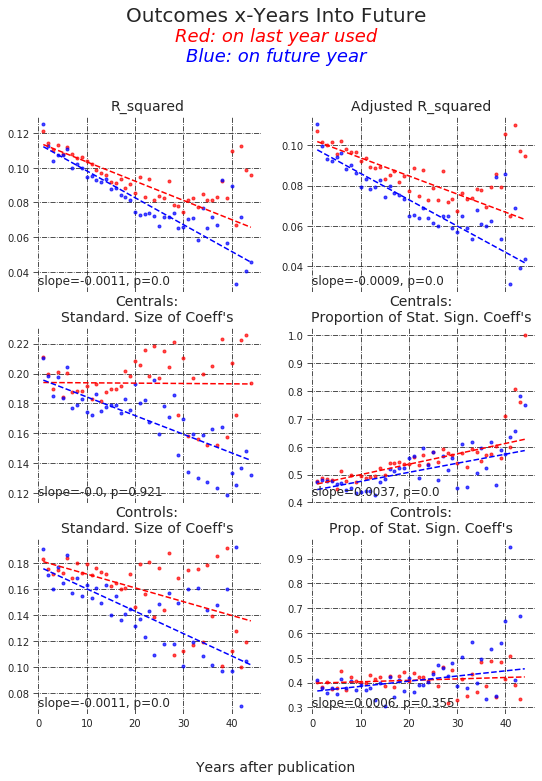

In [25]:
# group1 = 'on_last_year_of_data'
# group2 = 'on_future_year'    

YEARS = range(1, 2016-1972+1) # this was 43... now 44.. should be bigger?
results={}

outcomeMap = {'propSig_ControlVars':"Controls:\nProp. of Stat. Sign. Coeff's", 
              'paramSizesNormed_ControlVars':"Controls:\nStandard. Size of Coeff's",
              'Rs':'R_squared', 
              'adjRs':'Adjusted R_squared',
#               'pvalues':"Average P-Value of Coeff's",
              'propSig_CentralVars':"Centrals:\nProportion of Stat. Sign. Coeff's",
              'paramSizesNormed_CentralVars':"Centrals:\nStandard. Size of Coeff's" } 
#               'pvalues_CentralVars':"Cent. Var's: Average P-Value of Coeff's"}


f, axarr = plt.subplots(3, 2, sharex=True)
axarr = axarr.flatten()
f.set_size_inches(9,11)

# just re-arranging the list of outcomes so they get plotted in the order i want
outcomes_ordered = ['Rs', 
                    'adjRs',
                    'paramSizesNormed_CentralVars', 
                    'propSig_CentralVars',
                    'paramSizesNormed_ControlVars', 
                    'propSig_ControlVars']     

for i, outcome in enumerate(outcomes_ordered):
    
#     yerr = [2*np.std(x) for x in yearlyDiffs]
    meansGp1 = [df_holder[year][outcome, group1].mean() for year in YEARS]
    meansGp2 = [df_holder[year][outcome, group2].mean() for year in YEARS]
        
    xGp1, yGp1, xGp2, yGp2 = [], [], [], [] 
    for year in YEARS:
         xGp1.extend([year]*len(df_holder[year][outcome, group1]))
         yGp1.extend(df_holder[year][outcome, group1])
         xGp2.extend([year]*len(df_holder[year][outcome, group2]))
         yGp2.extend(df_holder[year][outcome, group2])

    axarr[i].plot(YEARS, meansGp1, '.', color='red', alpha=0.7)
    axarr[i].plot(YEARS, meansGp2, '.', color='blue', alpha=0.7)
    axarr[i].set_title(outcomeMap[outcome], fontsize=14)
    
    # add regression line
    formula = outcome+'~years'
#     result = smf.rlm(formula, data=pd.DataFrame({'years':x, outcome:y}).dropna(axis=0), missing='drop').fit()
    resultGp1 = smf.ols(formula, data=pd.DataFrame({'years':xGp1, outcome:yGp1}), missing='drop').fit()
    resultGp2 = smf.ols(formula, data=pd.DataFrame({'years':xGp2, outcome:yGp2}), missing='drop').fit()
    axarr[i].plot(YEARS, np.array(YEARS)*resultGp1.params[1] + resultGp1.params[0], 'r--', label='OnLastYearUsed')
    axarr[i].plot(YEARS, np.array(YEARS)*resultGp2.params[1] + resultGp2.params[0], 'b--', label='OnFutureYear')

    # add the slope and its p-value
    axarr[i].annotate('slope=' + str(np.around(resultGp1.params[1],4))+ ', p=' + str(np.around(resultGp1.pvalues[1],3)), 
                      xy=(0, 0), xycoords='axes fraction', fontsize=12, ha='left', va='bottom', 
                      xytext=(5,5), textcoords='offset points')
    
    # print the intercept and its p-value for my inspection, not on the figure
#     print 'intercept:'+str(result.params[0])+', '+str(result.pvalues[0])

# add title and common x-label
f.text(0.5, 0.05, 'Years after publication', ha='center',  va='bottom',fontsize=14)
f.text(0.5, 1, 'Outcomes x-Years Into Future', ha='center', fontsize=20)
f.text(0.5, 1-.025, 'Red: on last year used', ha='center', fontsize=18, style='italic', color='red')
f.text(0.5, 1-0.05, 'Blue: on future year', ha='center', fontsize=18, style='italic', color='blue')

# savefig('../../Images/2014-10-06-TWO-CURVES-outcomes_last_year_vs_x_years_into_future_all_8.png')

NOTE: 
--
**the x-axis in the graphs above is difficult is tricky because it doesn't show chronological time**

And I've already looked at trends in outcomes over time and didn't find any trends!

Plot number of points at each time period
--

Text(0.5,0,'Years after publication')

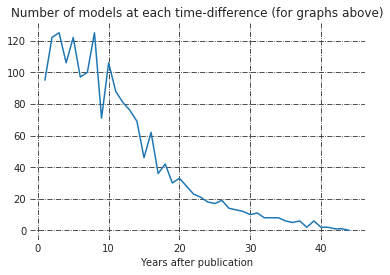

In [65]:
SIZES = [len(x) for x in onGp1]
plt.plot(YEARS, SIZES)
plt.title('Number of models at each time-difference (for graphs above)')
plt.xlabel('Years after publication')

Average 'last year used' and 'future_gss_year' vs time-gap
--

/home/t-9tepli/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/t-9tepli/.local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


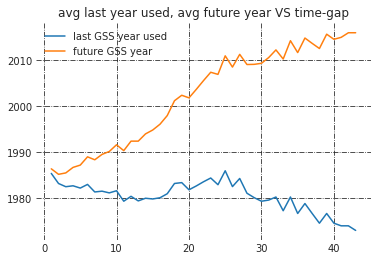

In [66]:
MAX_YEAR_USED = [np.mean(output[year]['metadata']['last_GSS_year_used']) for year in YEARS]
FUTURE_GSS_YEAR = [np.mean(output[year]['metadata']['future_GSS_year']) for year in YEARS]
plt.plot(YEARS, MAX_YEAR_USED, label='last GSS year used')
plt.plot(YEARS, FUTURE_GSS_YEAR, label='future GSS year')
plt.title('avg last year used, avg future year VS time-gap')
plt.legend()
# savefig('../../Images/2014-10-06-avg last year used vs avg future year vs time gap.png')

#NEW CODE: Plot the *differences* 


# Plot results of *real* models

intercept:-0.0012141636732122647, 0.44433889895392775
intercept:-0.004095963864884828, 0.009710877847813717
intercept:0.0015706222155315692, 0.5632349385938813
intercept:-0.020069384276124917, 0.05149839361111384
intercept:-0.00542039345304407, 0.1975243890234164
intercept:-0.032010038692458886, 0.0192611623592306


Text(0.5,0.383333,'Controls')

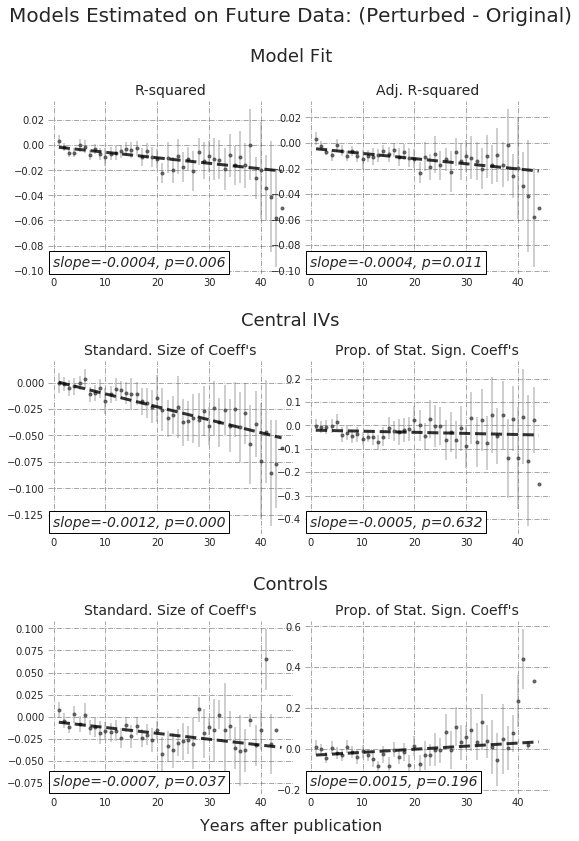

In [26]:
%matplotlib inline
group1 = 'on_last_year_of_data'
group2 = 'on_future_year'    
groups = [group1, group2]
    
# group1 = 'on_last_year_of_data'
# group2 = 'on_future_year'    

#ax.errorbar(x, y, yerr=yerr, fmt='o')

#fig, axs = plt.subplots(nrows=len(outcomes), ncols=1, sharex=True)

#fig = pl.figure(figsize=(3,8))
#fig = plt.figure(1, figsize=(8,25))

YEARS = range(1, 2016-1972+1)
results={}

outcomeMap = {'propSig_ControlVars':"Prop. of Stat. Sign. Coeff's", 
              'paramSizesNormed_ControlVars':"Standard. Size of Coeff's",
              'Rs':'R-squared', 
              'adjRs':'Adj. R-squared',
#               'pvalues':"Avg. P-Value of Coeff's",
              'propSig_CentralVars':"Prop. of Stat. Sign. Coeff's",
              'paramSizesNormed_CentralVars':"Standard. Size of Coeff's", 
              'pvalues_CentralVars':"Avg. P-Value of Coeff's"}


f, axarr = plt.subplots(nrows=3, ncols=2) # sharex=True
f.subplots_adjust(top=1, hspace=0.5, wspace=0.05)
axarr = axarr.flatten()
f.set_size_inches(9,11)

# just re-arranging the list of outcomes so they get plotted in the order i want
outcomes_ordered = ['Rs', 
                    'adjRs',
                    'paramSizesNormed_CentralVars', 
                    'propSig_CentralVars',
                    'paramSizesNormed_ControlVars', 
                    'propSig_ControlVars']             

for i, outcome in enumerate(outcomes_ordered):
    
    yearlyDiffs = [df_holder[year][outcome, group2] - df_holder[year][outcome, group1] for year in YEARS]  
    yerr = [1.96*x.std()/np.sqrt(len(x)) for x in yearlyDiffs]
    means = [x.mean() for x in yearlyDiffs]

    #for clustered errors
    article_indices = pd.concat([df_holder[year]['article_id'] for year in YEARS])
    article_indices = np.array(article_indices.index)

    x, y = [], []  
    for yr in range(len(yearlyDiffs)):
         x.extend([yr]*len(yearlyDiffs[yr]))
         y.extend(yearlyDiffs[yr])
    x = np.array(x)
    y = np.array(y)

    axarr[i].plot(YEARS, means, '.', color='0.25', alpha=0.75)
 
    # the err below underestimates the error because those aren't clustered. but these are used for visualizatioiin purposes
    # only so it doesn't matter that much
    axarr[i].errorbar(YEARS, means, yerr=yerr, linestyle='None', alpha=0.5, color='gray')

    # add regression line
    mask = ~np.isnan(y)
    result = smf.ols(formula=outcome+'~years', 
                     data=pd.DataFrame({'years':x[mask], outcome:y[mask]}).dropna(axis=0),
                     missing='drop').fit(cov_type='cluster', 
                                         cov_kwds=dict(groups=article_indices[mask]))
    axarr[i].plot(YEARS, np.array(YEARS)*result.params[1] + result.params[0], '--', color='0', linewidth=3, alpha=0.8)
    
    # add error bars
#     clusteredSES = []
#     article_ids = np.array(list(df_output.index)) 
#     for outcome in outcomesToUse:
#     mask = ~np.isnan(np.array(diffs))
#     diff = 100*(df_output[group2, outcome] - df_output[group1, outcome])
#     result_clustered = smf.ols(formula='y~x-1', \
#                      data=pd.DataFrame({'y':diff[mask], 'x':[1]*len(diff[mask])})).fit(missing='drop', \
#                                                                              cov_type='cluster', \
#                                                                     cov_kwds=dict(groups=article_ids[mask]))
#     clusteredSES.append(result_clustered.HC0_se[0])    
    
    # add the slope and its p-value
    axarr[i].annotate('slope=%0.4f, p=%0.3f' % (result.params[1], result.pvalues[1]), 
                      xy=(0, 0), xycoords='axes fraction', fontsize=14, ha='left', va='bottom', 
                      xytext=(5,5), textcoords='offset points', bbox=dict(facecolor='white', alpha=1), style='italic')
    
    # print the intercept and its p-value for my inspection, not on the figure
    print 'intercept:'+str(result.params[0])+', '+str(result.pvalues[0])

    axarr[i].set_title(outcomeMap[outcome], fontsize=14)    
    axarr[i].grid(alpha=0.5)
#     axarr[i].set_xlim(0,42)
    
# add title and common x-label
f.text(0.5, 0.075, 'Years after publication', ha='center',  va='bottom',fontsize=16)
f.text(0.5, 1+0.1, 'Models Estimated on Future Data: (Perturbed - Original)', ha='center', fontsize=20)

f.text(0.5, 1+.05, 'Model Fit', ha='center', fontsize=18)
f.text(0.5, 2/3+.05, 'Central IVs', ha='center', fontsize=18)
f.text(0.5, 1/3+.05, 'Controls', ha='center', fontsize=18)

# plt.savefig('images/models-over-time.svg', bbox_inches='tight', dpi=150)

# Generate trends for *random* models

OLD CODE: Second, plot the *differences* in outcomes between last_year_used and future_year
--

In [ ]:
# # group1 = 'on_last_year_of_data'
# # group2 = 'on_future_year'    

# #ax.errorbar(x, y, yerr=yerr, fmt='o')

# #fig, axs = plt.subplots(nrows=len(outcomes), ncols=1, sharex=True)

# #fig = pl.figure(figsize=(3,8))
# #fig = plt.figure(1, figsize=(8,25))
# YEARS = range(43)
# results={}

# outcomeMap = {'propSig':"Proportion of Stat. Sign. Coeff's", 
#               'paramSizesNormed':"Standard. Size of Coeff's",
#               'Rs':'R_squared', 
#               'adjRs':'Adjusted R_squared',
#               'pvalues':"Average P-Value of Coeff's",
#               'propSig_CentralVars':"Cent. Var's: Proportion of Stat. Sign. Coeff's",
#               'paramSizesNormed_CentralVars':"Cent. Var's: Standard. Size of Coeff's", 
#               'pvalues_CentralVars':"Cent. Var's: Average P-Value of Coeff's"}


# f, axarr = plt.subplots(4, 2, sharex=True)
# axarr = axarr.flatten()
# f.set_size_inches(9,11)

# # just re-arranging the list of outcomes so they get plotted in the order i want
# outcomes_ordered = ['propSig', 'propSig_CentralVars',
#               'paramSizesNormed', 'paramSizesNormed_CentralVars', 
#               'pvalues','pvalues_CentralVars',
#                'Rs', 'adjRs']

# for i, outcome in enumerate(outcomes_ordered):
    
#     yearlyDiffs = [np.array(output[year][group2][outcome]) - np.array(output[year][group1][outcome]) for year in YEARS]  
#     yerr = [2*np.std(x)/np.sqrt(len(x)) for x in yearlyDiffs]
#     means = [np.mean(x) for x in yearlyDiffs]
    
#     x, y = [], []  
#     for yr in YEARS:
#          x.extend([yr]*len(yearlyDiffs[yr]))
#          y.extend(yearlyDiffs[yr])
# #          y_means.append(np.mean(output[yr][group2][outcome]))

#     #         for diffy in yearlyDiffs[j]:
# #             x.append(j)
# #             y.append(diffy)    
            
#     # note, i'm plotting means because plotting each point makes the plot crowded,
#     # but i'm calculating the regression line on the un-aggregated data!    
# #     plot(years, means, '.', alpha=0.8)  

#     # i am not plotting the line below because it changes the y-axis and it's hard to see any trend!!!
# #     axarr[i].plot(x, y, '.', alpha=0.1)
# #            errorbar(years, means, yerr=yerr)

# #     ylabel('Change in ' + outcomeMap[outcome])

#     axarr[i].plot(YEARS, means, '.')
#     axarr[i].set_title(outcomeMap[outcome], fontsize=14)
    
#     # add regression line
#     formula = outcome+'~years'
# #     result = smf.rlm(formula, data=pd.DataFrame({'years':x, outcome:y}).dropna(axis=0), missing='drop').fit()
#     result = smf.ols(formula, data=pd.DataFrame({'years':x, outcome:y}).dropna(axis=0), missing='drop').fit()
#     axarr[i].plot(YEARS, np.array(YEARS)*result.params[1] + result.params[0], 'r--')

#     # add the slope and its p-value
#     axarr[i].annotate('slope=' + str(np.around(result.params[1],4))+ ', p=' + str(np.around(result.pvalues[1],3)), 
#                       xy=(0, 0), xycoords='axes fraction', fontsize=12, ha='left', va='bottom', 
#                       xytext=(5,5), textcoords='offset points')
    
#     # print the intercept and its p-value for my inspection, not on the figure
#     print 'intercept:'+str(result.params[0])+', '+str(result.pvalues[0])

# # add title and common x-label
# f.text(0.5, 0.05, 'Years after publication', ha='center',  va='bottom',fontsize=14)
# f.text(0.5, 1-0.05, 'Outcomes x-Years Into Future', ha='center', fontsize=20)

# # savefig('../../Images/9-29-2014--outcomes_last_year_vs_x_years_into_future_all_8.png')

Robustness check
--

Description: 
Use *clustered standard errors* to do significance tests.
Note: I am not using the 'df_correction' flag in get_robustcov_results() because that's apparently something HLM does, not canonical clustered errors:
"This method of correcting the standard errors to account for the intraclass correlation is a "weaker" form of correction than using a multilevel model, which not only accounts for the intraclass correlation, but also corrects the denominator degrees of freedom for the number of clusters."
source: http://www.ats.ucla.edu/stat/stata/library/cpsu.htm

Outcome
--
All outcomes are still p < 0.05 (!!!) except the time-trends in p-values, which are not p > 0.05. 


In [ ]:
# group1 = 'on_last_year_of_data'
# group2 = 'on_future_year'    

#ax.errorbar(x, y, yerr=yerr, fmt='o')

#fig, axs = plt.subplots(nrows=len(outcomes), ncols=1, sharex=True)

#fig = pl.figure(figsize=(3,8))
#fig = plt.figure(1, figsize=(8,25))
YEARS = range(43)
results={}

outcomeMap = {'propSig':"Proportion of Stat. Sign. Coeff's", 
              'paramSizesNormed':"Standard. Size of Coeff's",
              'Rs':'R_squared', 
              'adjRs':'Adjusted R_squared',
              'pvalues':"Average P-Value of Coeff's",
              'propSig_CentralVars':"Cent. Var's: Proportion of Stat. Sign. Coeff's",
              'paramSizesNormed_CentralVars':"Cent. Var's: Standard. Size of Coeff's", 
              'pvalues_CentralVars':"Cent. Var's: Average P-Value of Coeff's"}


f, axarr = plt.subplots(4, 2, sharex=True)
axarr = axarr.flatten()
f.set_size_inches(9,11)

# just re-arranging the list of outcomes so they get plotted in the order i want
outcomes_ordered = ['propSig', 'propSig_CentralVars',
              'paramSizesNormed', 'paramSizesNormed_CentralVars', 
              'pvalues','pvalues_CentralVars',
               'Rs', 'adjRs']

for i, outcome in enumerate(outcomes_ordered):
    
    x, y, yerr, means = [], [], [], []  
    article_indices = []
    
    for yr in YEARS:
        yearlyDiffs = np.array(output[yr][group2][outcome]) - \
                                np.array(output[yr][group1][outcome])  
        x.extend([yr]*len(yearlyDiffs))
        y.extend(yearlyDiffs)
        means.append(np.mean(yearlyDiffs))
        yerr.append(2*np.std(yearlyDiffs))

        article_indices.extend(output[yr]['metadata']['articleID'])

        #          y_means.append(np.mean(output[yr][group2][outcome]))

    #         for diffy in yearlyDiffs[j]:
#             x.append(j)
#             y.append(diffy)    
            
    # note, i'm plotting means because plotting each point makes the plot crowded,
    # but i'm calculating the regression line on the un-aggregated data!    
#     plot(years, means, '.', alpha=0.8)  

    # i am not plotting the line below because it changes the y-axis and it's hard to see any trend!!!
#     axarr[i].plot(x, y, '.', alpha=0.1)
#            errorbar(years, means, yerr=yerr)

#     ylabel('Change in ' + outcomeMap[outcome])

    axarr[i].plot(YEARS, means, '.')
    axarr[i].set_title(outcomeMap[outcome], fontsize=14)
    
    # add regression line
    formula = outcome+'~years'
#     result = smf.rlm(formula, data=pd.DataFrame({'years':x, outcome:y}).dropna(axis=0), missing='drop').fit()
    result = smf.ols(formula, data=pd.DataFrame({'years':x, outcome:y}).dropna(axis=0), \
                     missing='drop').fit(cov_type='cluster', \
                                         cov_kwds=dict(groups=article_indices))
    
    axarr[i].plot(YEARS, np.array(YEARS)*result.params[1] + result.params[0], 'r--')

# section below no longer necessary because i'm passing keyword args for 'cluster' into the model.fit() method above
#     # GET CLUSTERED ERRORS
#     robust_results = result.get_robustcov_results(cov_type='cluster', 
#                                                   groups=article_indices, 
#                                                   df_correction=True) # try True
    
    

    # add the slope and its p-value
    axarr[i].annotate('slope=' + str(np.around(result.params[1],4))+ \
                      ', p=' + str(np.around(result.pvalues[1],3)), \
                      xy=(0, 0), xycoords='axes fraction', fontsize=12, ha='left', va='bottom', \
                      xytext=(5,5), textcoords='offset points')
    
    # print the intercept and its p-value for my inspection, not on the figure
    print 'intercept:'+str(result.params[0])+', '+str(result.pvalues[0])    

# add title and common x-label
f.text(0.5, 0.05, 'Years after publication', ha='center',  va='bottom',fontsize=14)
f.text(0.5, 1-0.05, 'Robustness Test: Outcomes after Publication', ha='center', fontsize=18)
f.text(0.5, 1-0.07, 'using Clustered Standard Errors', ha='center', fontsize=18)

# savefig('../../Images/10-23-2014--robustness_test--outcomes_after_publication_with_clustered_errors.png')